Due to difficulties converting a Pytorch model to a Tensorflow model, this notebook uses the same CNN model as before, but written in Tensorflow. This allows it to be portable to an Android device.

In [108]:
# imports 
import numpy as np
import os
import os.path as path
import librosa

from PIL import Image

import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.keras.models import Model
from tensorflow.math import confusion_matrix
# tf.compat.v1.disable_eager_execution()

from tflite_runtime.interpreter import Interpreter

print('TensorFlow version:',tf.__version__)
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)

TensorFlow version: 2.12.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [109]:
# Parameters 
MODEL_NAME = 'audio_mnist'
EPOCHS = 20
BATCH_SIZE = 64

# Parameters used on tablet 
VOICED_THRESHOLD = 20000000
FRAME_SETBACK = 2
FS = 48000
DOWN_SAMPLED_FS = 8000
NFFT = 256
NOVERLAP = -1
NFILT = 40
NUM_CEPS = 13
NN_DATA_COLS = 28
NN_DATA_ROWS = 12
PREEMPHASIS_B = 0.97
PIXEL_WIDTH = 400
PIXEL_HEIGHT = 300

In [110]:
def relu6(x):
    return tf.keras.activations.relu(x, max_value=6)


class NeuralNet(tf.keras.Model):
    def __init__(self, out_size):
        super(NeuralNet, self).__init__()
        self.rescaling = tf.keras.layers.Rescaling(1./255, input_shape=(300, 400, 3))
        self.conv1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), activation=relu6, padding='same', kernel_initializer='he_uniform')
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation=relu6, padding='same', kernel_initializer='he_uniform')
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.1)
        self.dropout_2 = tf.keras.layers.Dropout(rate=0.16)
        self.dropout_3 = tf.keras.layers.Dropout(rate=0.12)

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(units=5000, activation='relu', kernel_initializer='he_uniform')
        self.dense_2 = tf.keras.layers.Dense(units=1000, activation='relu', kernel_initializer='he_uniform')
        self.dense_3 = tf.keras.layers.Dense(units=out_size, activation='softmax', kernel_initializer='he_uniform')

        # self.loss_fn = loss_fn
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=lrate, momentum=0.9, weight_decay=weight_decay)

    def call(self, x):
        x = self.rescaling(x)
        # print("Done rescaling")
        x = self.conv1(x)
        # print("Done conv1")
        x = self.maxpool(x)
        # print("Done maxpool1")
        x = self.conv2(x)
        # print("Done conv2")
        x = self.maxpool(x)
        # print("Done maxpool2")
        x = self.dropout_1(x, training=True)
        # print("Done droput1")
        x = self.flatten(x)
        # print("Done flatten")
        x = self.dense_1(x)
        # print("Done dense 1")
        x = self.dropout_2(x, training=True)
        # print("Done dropout 2")
        x = self.dense_2(x)
        # print("Done dense 3")
        x = self.dropout_3(x, training=True)
        # print("Done dropout 3")
        x = self.dense_3(x)
        # print("Done dense 3")
        return x

(300, 400, 4)


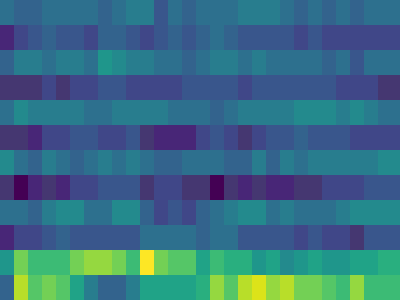

0x33
0x63
0x8d
0xff


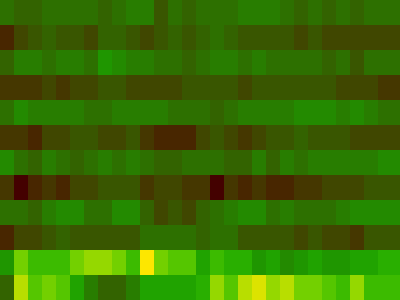

In [111]:
# Checking the data set

path = "MFCC_Images/0/mfcc_images/Mon May 01 14:35:23 CDT 2023_mfcc.png"
test_image = Image.open(path)
image_data = np.array(test_image)
print(image_data.shape)
display(test_image)

for i in range(4):
    print("{}".format(hex(image_data[10][20][i])))

""" 
Noticed that the fourth channel is alpha which is always xFF.
Now I will try to figure out the RGB order by mutating the image.
"""
for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        pixel = image_data[i,j]
        pixel[2] = 0
"""
From experimentation:
    channel 0 -- r
    channel 1 -- g
    channel 2 -- b
    channel 3 -- alpha (always 0xFF) (also must be the most signicant byte)

This is good because it verifies that the breakdown is the same as the images on the Android tablet. 
"""
# now figure out which channel is green
mutated_image = Image.fromarray(image_data)
display(mutated_image)

In [112]:
# Loading the dataset
train_files_per_label = 50
dev_files_per_label = 60 - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/mfcc_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(len(image_directory)):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (500, 300, 400, 4)
after shuffle shape: (500, 300, 400, 4)
len train set: 500
len train label set: 500
len dev set: 100
len dev label set: 100
[3. 6. 6. 7. 0. 3. 9. 4. 2. 6. 9. 9. 3. 9. 2. 4. 8. 2. 1. 6. 7. 8. 5. 7.
 1. 5. 4. 5. 8. 0. 3. 4. 2. 7. 7. 9. 9. 9. 6. 2. 2. 8. 2. 3. 6. 6. 2. 3.
 6. 1. 2. 7. 0. 5. 4. 3. 9. 3. 9. 0. 4. 0. 1. 2. 3. 4. 4. 0. 7. 2. 9. 1.
 7. 0. 5. 4. 8. 0. 4. 6. 5. 2. 3. 6. 9. 2. 7. 4. 8. 8. 8. 9. 2. 1. 1. 8.
 5. 1. 1. 8. 3. 4. 6. 6. 8. 0. 9. 6. 7. 1. 6. 5. 2. 1. 2. 3. 8. 4. 0. 8.
 5. 4. 7. 0. 1. 9. 8. 3. 9. 3. 4. 1. 1. 5. 0. 8. 8. 7. 5. 2. 5. 2. 9. 2.
 5. 6. 3. 6. 6. 9. 5. 4. 5. 9. 7. 1. 3. 3. 7. 1. 0. 1. 3. 2. 2. 5. 8. 4.
 3. 9. 1. 4. 2. 5. 9. 5. 6. 4. 4. 1. 8. 6. 4. 4. 0. 7. 7. 9. 5. 3. 5. 6.
 3. 2. 4. 0. 8. 6. 6. 9. 4. 7. 2. 0. 1. 9. 9. 9. 0. 0. 1. 9. 3. 2. 5. 0.
 8. 7. 7. 8. 8. 6. 3. 2. 1. 0. 0. 7. 0. 7. 5. 8. 9. 7. 0. 6. 3. 7. 9. 2.
 7. 1. 3. 1. 1. 5. 3. 6. 8. 2. 9. 7. 4. 3. 9. 5. 6. 6. 2. 4. 3. 9. 3. 3.
 4. 2. 0. 9. 5. 5. 1. 8. 4. 6. 1

In [113]:
# running dataset on model 
input_dim = 12 # num ceps - 1
output_dim = 10 # number of genres
weight_decay = 1e-2
learning_rate = 1e-2

input_layer = Input(shape=(PIXEL_HEIGHT, PIXEL_WIDTH, 3), dtype=tf.int8)
x = NeuralNet(output_dim)(input_layer)

model = Model(inputs=input_layer, outputs=x)

# printing a view of the model
print(model.summary(expand_nested=True))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300, 400, 3)]     0         
                                                                 
 neural_net_9 (NeuralNet)    (None, 10)                158018110 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| rescaling_2 (Rescaling)   multiple                  0         |
|                                                               |
| conv2d_18 (Conv2D)        multiple                  280       |
|                                                               |
| max_pooling2d_9 (MaxPooling  multiple               0         |
| 2D)                                                           |
|                                                               |
| conv2d_19 (Conv2D)        multiple                  1820      |
|                                                          

In [114]:
# training the model now
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=weight_decay), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics="acc")
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=weight_decay), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics="acc")
history = model.fit(x=train_set, y=train_set_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(dev_set, dev_set_labels))

Epoch 1/20
8/8 [==============================] - 4s 498ms/step - loss: 2.6195 - acc: 0.3040 - val_loss: 1.7622 - val_acc: 0.4200
Epoch 2/20
8/8 [==============================] - 4s 466ms/step - loss: 1.0565 - acc: 0.7580 - val_loss: 0.6536 - val_acc: 0.8900
Epoch 3/20
8/8 [==============================] - 4s 480ms/step - loss: 0.6570 - acc: 0.8300 - val_loss: 0.5408 - val_acc: 0.8400
Epoch 4/20
8/8 [==============================] - 4s 487ms/step - loss: 0.2332 - acc: 0.9660 - val_loss: 0.2316 - val_acc: 0.9700
Epoch 5/20
8/8 [==============================] - 4s 466ms/step - loss: 0.1243 - acc: 0.9900 - val_loss: 0.1412 - val_acc: 0.9900
Epoch 6/20
8/8 [==============================] - 4s 458ms/step - loss: 0.0770 - acc: 1.0000 - val_loss: 0.1687 - val_acc: 0.9400
Epoch 7/20
8/8 [==============================] - 4s 467ms/step - loss: 0.0660 - acc: 0.9960 - val_loss: 0.1046 - val_acc: 0.9900
Epoch 8/20
8/8 [==============================] - 4s 476ms/step - loss: 0.0426 - acc: 1.00

In [115]:
model.save('my_model')

loaded_model = tf.keras.models.load_model('my_model')

# Convert the model to the TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the converted model
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)

2023-05-01 19:07:51.449670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,34,45,20]
	 [[{{node inputs}}]]
2023-05-01 19:07:51.460955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5000]
	 [[{{node inputs}}]]
2023-05-01 19:07:51.469709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1000]
	 [[{{node inputs}}]]
2023-05-0

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpt3begs8z/assets


INFO:tensorflow:Assets written to: /tmp/tmpt3begs8z/assets
2023-05-01 19:07:54.471642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-01 19:07:54.471666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-01 19:07:54.471804: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt3begs8z
2023-05-01 19:07:54.472611: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-01 19:07:54.472620: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt3begs8z
2023-05-01 19:07:54.475026: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-01 19:07:54.630340: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpt3begs8z
2023-05-01 19:07:54.638716: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

In [119]:
model_path = 'my_model.tflite'
interpreter = Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
single_test = np.reshape(dev_set[0], (1, 300, 400, 3))
interpreter.set_tensor(input_details[0]['index'], single_test)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

print("Top 3 prections by (value, label)")
print(sorted(zip(output_data, [i for i in range(10)]), reverse=True)[:3])
print("Actual label was: {}\n".format(dev_set_labels[0]))

[{'name': 'serving_default_input_10:0', 'index': 0, 'shape': array([  1, 300, 400,   3], dtype=int32), 'shape_signature': array([ -1, 300, 400,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 43, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Top 3 prections by (value, label)
[(0.9983063, 4), (0.0005980613, 1), (0.00042299737, 5)]
Actual label was: 4.0

